<a href="https://colab.research.google.com/github/EduardMozharov/ML_Neural_networks/blob/main/Project_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project "Emotion Detection"
Итоговая работа курса SKILLBOX:  
Data Science. ML. Средний уровень (Нейронны сети))

# Задание
**Цель** - реализовать нейронную сеть, распознающую эмоции

**Задачи:**
1. Работа требует реализации алгоритма, с помощью которого будет происходить заданная классификация. Приветствуется использование архитектур свёрточных нейронных сетей, разобранных во время теоретических занятий. Время инференса сети на Google Colab не должно превышать 0,33 секунды (3 кадра в секунду).

2. Создать скрипт, который будет работать с их веб-камерами и выводить на экран текущую эмоцию.


**Дополнительно:**  
1. Используйте подходы по искусственному увеличению датасета для обучения, а именно — аргументации, рассмотренные в курсе.
2. Используйте продвинутые техники обучения, такие как finetuning и другие, рассмотренные в курсе.
3. Пишите структурный код (основная логика кода должна быть вынесена в классы/методы/функции + осмысленный нейминг сущностей и комментарии).
4. Проведите эксперименты с valence-arousal разложением эмоций, когда модель обучается не на самих эмоциях, а на их разложении по этим двум компонентам. Информация о подобном разложении есть в дополнительных материалах.

 
Работающий прототип из пункта «Улучшение и дополнения к заданию» прибавляет один балл к итоговой оценке и добавляет в портфолио ценный ML-проект.




# 1 Загрузим необходимые библиотеки

In [ ]:
DO_IT = True # Выполнять ли особые части кода

In [ ]:
!pip install livelossplot

# Для работы оптимизатора TensorRT может потребоваться предыдущая версия tensorflow
#!pip install -U tensorflow==2.7.0
#!pip install keras==2.6.*

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import osb
import random

import tensorflow as tf
print('TensorFlow version:', tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from livelossplot.tf_keras  import PlotLossesCallback

import timeit

TensorFlow version: 2.9.2


#2. Загрузим данные и рассмотрим их

## 2.1 Загрузим рисунки

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# Один раз загрузим и разархивируем данные на личный диск,
# чтобы каждый раз заново не загружать данные
path = '/content/drive/MyDrive/SKILLBOX/FinalWorks/ML/'
#os.chdir(path)
#!unzip -q train.zip
#!unzip -q test_kaggle.zip

## 2.2. Загрузим табличные данные и рассмотрим их

In [5]:
# Загрузим таблицу с описанием данных train
df = pd.read_csv(path+'train.csv')
n_data = df.shape[0]
print('Количество строк данных', n_data)
df.head()

Количество строк данных 50046


,Unnamed: 0,image_path,emotion
0,0,./train/anger/0.jpg,anger
1,1,./train/anger/1.jpg,anger
2,2,./train/anger/10.jpg,anger
3,3,./train/anger/100.jpg,anger
4,4,./train/anger/1000.jpg,anger


In [6]:
emotions = df.emotion.unique()
n_emotions = emotions.shape[0]

print("Всего эмоций {}: {} ".format(n_emotions, emotions))

Всего эмоций 9: ['anger' 'contempt' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise'
 'uncertain'] 


**image_path** - строка, являющаюся путем до изображения в случае обучения или названием изображения в случае теста  
**emotion** - строка, характеризующая эмоцию  

  
В данном задании требуется предсказать 9 базовых эмоций, таких как:  
* **neutral** - нейтральная эмоция
* **anger**- гнев, злость
* **contempt** - презрение
* **disgust** - отвращение
* **fear** - страх
* **happy** - веселый
* **sad** - грусть
* **surprise** - удивленность
* **uncertain** - неуверенность

In [7]:
df_count = df.groupby('emotion').count()['image_path']
df_count

emotion
anger        7022
contempt     3085
disgust      3155
fear         5044
happy        5955
neutral      6795
sad          6740
surprise     6323
uncertain    5927
Name: image_path, dtype: int64

## 2.3 Рассмотрим рисунки

In [8]:
def show_test_img(img_ind=1):
  img = plt.imread(path+df['image_path'][img_ind][2:])
  plt.imshow(img)
  plt.title(df['emotion'][img_ind])

def show_random_test_img(n_img=10):
  
  #axs = plt.Figure(figsize=(), )
  img_ind = random.randint(0, n_data)
  show_test_img(img_ind)

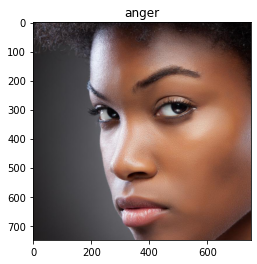

In [11]:
show_test_img(1)

# 3. Подготовка данных. Аугментация.


In [15]:
BATCH_SIZE = 100
IMG_SHAPE  = 150 



In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.preprocessing

In [18]:
?ImageDataGenerator

In [ ]:
# Выполним Аугментацию
image_gen_aug = ImageDataGenerator(
      rescale=1./255,
      rotation_range=10,  # максимальный угол поворота
      width_shift_range=0.2, # смещение максимум на 20% ширины по горизонтали
      height_shift_range=0.2, # смещение максимум на 20% высоты по вертикали
      zoom_range=0.2, # картинка будет увеличена или уменьшена не более чем на 20% 
      horizontal_flip=False, # случайное отражение по горизонтали
      vertical_flip=False, # случайное отражение по вертикали
      fill_mode="nearest", # чем заполнять пробелы -- сначала выберем черный цвет, а потом изменим на "nearest"
      #cval=0,
      ) 


sample_aug = image_gen_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=False,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')


In [ ]:
# Тренировочные и валидационные данные
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                              class_mode='binary')

In [ ]:
def show_catsdogs(images, labels, predicted_labels=None):
    names = {0: "Cat", 1: "Dog"}
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

#3. Модель #1

В ходе выполнения работы придерживаемся следующих правил по оптимизации времения выполнения сети:
1) Оптимизация модели при обучении:
   * 1.1)  От простой модели к сложной.
   * 1.2) Не заставлять учить то, что задается явно.
   * 1.3) Понизить ширину сети за счет Conv(1х1).
   * 1.4) Заменить Conv+Pool2D на Strided Conv.
   * 1.5) Использовать активацию Relu по возможности.
   * 1.6) Количество карт признаков делать кратным 8.
   * 1.7) Применить поканальную сепарабельную свертку (Depth-wise separable Conv).
   * 1.8) Применить Прореживание (Puring).
   * 1.9) Другое... 

2) Оптимизация модели после обучения: с помощью TensorRT

In [16]:
model_1 = tf.keras.Sequential()
model_1 .add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),
                                 padding='same', activation='relu',
                                 input_shape=(IMG_SHAPE,IMG_SHAPE,3),
                                 strides=(2,2)))
model_1 .add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),
                                 padding='same', activation='relu',
                                 strides=(2,2)))
model_1 .add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3),
                                 padding='same', activation='relu',
                                 strides=(2,2)))
model_1 .add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3),
                                 padding='same', activation='relu',
                                 strides=(2,2)))
model_1 .add(tf.keras.layers.Flatten())
model_1 .add(tf.keras.layers.Dense(128, activation='relu'))
model_1 .add(tf.keras.layers.Dense(1, activation='softmax'))
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 75, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 128)       147584    
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 128)               1638528   
                                                                 
 dense_1 (Dense)             (None, 1)                

#3.1 Проверим время работы одного прохода нейронной сети

In [ ]:
%%timeit -n 10 -r 10
q_opt = model_opt_3(np.random.rand(1, inp_size, inp_size, 3).astype(np.float32))

## 3.2. Обучение модели

In [ ]:
# указанными параметрами спустя 30 эпох вы увидите точность около 75%. 
# если вас что-то насторожит в графиках, запомните это, это нормально :)
EPOCHS = 30
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()]) # мы добавили коллбек для отрисовки прогресса

# 4. Модель #2 - с применением Fine-Tuning
За основу возьмем сеть VGG19, обученную на ImageNet

In [19]:
model_vgg19 = tf.keras.applications.VGG19(weights='imagenet')  

In [ ]:
# Заморозим модель
model_vgg19.trainable = False
# Возьмем все слои кроме нескольких последних

#Дополним модель своими слоями
model_2 = tf.keras.Sequential([model_vgg19])

#5. Оптимизация модели

# 6. Проведите эксперименты с valence-arousal разложением эмоций, когда модель обучается не на самих эмоциях, а на их разложении по этим двум компонентам